In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
audio_file = "../input/simplespeech/14/19021240_NguyenTrongDat/2.wav"

In [3]:
ipd.Audio(audio_file)

In [4]:
# load audio files with librosa
signal, sr = librosa.load(audio_file)

In [5]:
print(sr)

22050


In [6]:
mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sr)

In [7]:
mfccs.shape

(13, 270)

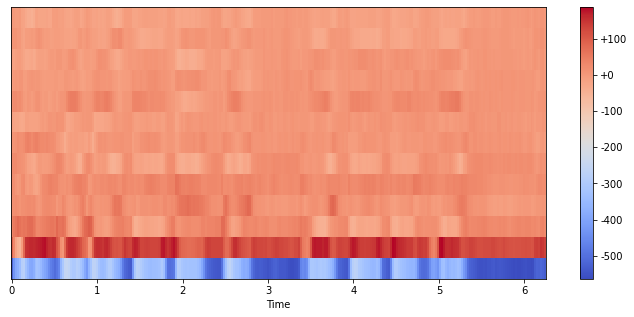

In [8]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [9]:
delta_mfccs = librosa.feature.delta(mfccs)

In [10]:
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

In [11]:
delta_mfccs.shape

(13, 270)

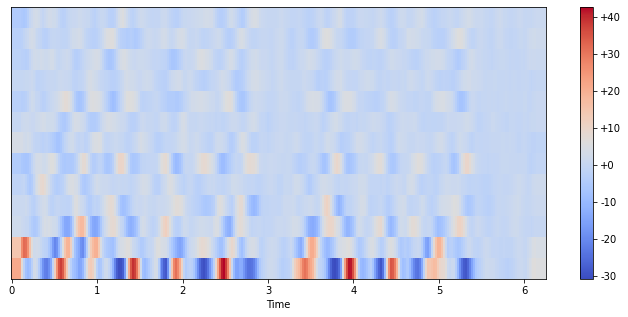

In [12]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

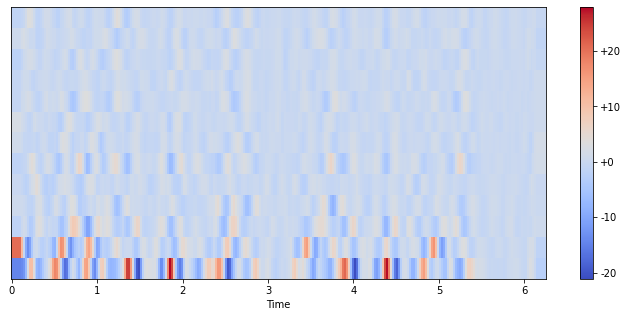

In [13]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(delta2_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [14]:
mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))

In [15]:
mfccs_features.shape

(39, 270)

In [16]:
class_names = ['xuong', 'len', 'phai', 'trai', 'nhay', 'ban', 'a', 'b', 'sil']

In [17]:
for i in class_names:
    !mkdir $i

In [18]:
!ls

__notebook__.ipynb  a  b  ban  len  nhay  phai	sil  trai  xuong


In [19]:
input_path = '../input/simplespeech/14/'
output_path = './'
from pydub import AudioSegment
def split_wav(t1,t2,name,dir_name,name_export):
    t1 = t1 * 1000 #Works in milliseconds
    t2 = t2 * 1000
    name = input_path + dir_name +'/'+ name
    newAudio = AudioSegment.from_wav(name)
    newAudio = newAudio[t1:t2]
    name_export = output_path + name_export +".wav"
    newAudio.export(name_export, format="wav")

In [20]:
count = 0
import os
import pandas as pd
for name_dir in os.listdir(os.path.join(input_path)):
    for i in os.listdir(os.path.join(input_path, name_dir)):
        if i.endswith('.wav'):
            path = i[:-3]
            path_txt = path + 'txt'
            if(os.path.exists(os.path.join(input_path,name_dir,path_txt))):
                df = pd.read_csv(os.path.join(input_path,name_dir,path_txt), sep="\t", header=None)
                for index, row in df.iterrows():
                    count+=1
                    isdir = os.path.isdir(path)
                    if(row[2]=='sli'):
                        row[2] = 'sil'
                    row[2]=row[2].replace(" ", "")
                    row[2]=row[2].lower()
                    if(row[2]=='pha'):
                        row[2] = 'phai'

                    if row[2]=='suong':
                        row[2] = 'xuong'
                    if row[2]=='xuon':
                        row[2] = 'xuong'
                    name_export = row[2] +'/'+ str(count)
                    split_wav(row[0],row[1],i,name_dir,name_export)
                




In [21]:
print(count)

4584


In [22]:

states = [9, 9, 9, 9, 6, 9, 9, 9, 9]

In [23]:
import librosa
import numpy as np
import os
import math
from sklearn.cluster import KMeans
import hmmlearn.hmm

def get_mfcc(file_path):
    y, sr = librosa.load(file_path) # read .wav file
#     hop_length = math.floor(sr*0.010) # 10ms hop
    hop_length = 256
#     win_length = math.floor(sr*0.025) # 25ms frame
    win_length = 512
    # mfcc is 12 x T matrix
    mfcc = librosa.feature.mfcc(
        y=y, sr=sr, n_mfcc=13, n_fft=1024,
        hop_length=hop_length, win_length=win_length)
    # substract mean from mfcc --> normalize mfcc
#     mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1,1)) 
    mfcc = np.subtract(mfcc,np.mean(mfcc))
    # delta feature 1st order and 2nd order
    delta1 = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    # X is 39 x T
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # O^r
    # return T x 39 (transpose of X)
    return X.T # hmmlearn use T x N matrix

In [24]:
a = get_mfcc('../input/simplespeech/14/19020061_DuongNganHa/11-20.wav')
print(type(a.shape))

<class 'tuple'>


In [25]:
#clean file
for cname in class_names:
    file_paths = [os.path.join("./", cname, i) for i in os.listdir(os.path.join('./', cname)) if i.endswith('.wav')]
    for file_path in file_paths:
        try:
            get_mfcc(file_path)
        except:
            print(file_path)
            !rm $file_path
all_data = {}
all_labels = {}
for cname in class_names:
    file_paths = [os.path.join("./", cname, i) for i in os.listdir(os.path.join('./', cname)) if i.endswith('.wav')]
    data = [get_mfcc(file_path) for file_path in file_paths]
    all_data[cname] = data
    all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]

./sil/1201.wav
./sil/1249.wav
./sil/2812.wav


/opt/conda/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=1024 is too small for input signal of length=0
  return f(*args, **kwargs)


./sil/3180.wav
./sil/492.wav


In [26]:
from sklearn.model_selection import train_test_split

X = {'train': {}, 'test': {}}
y = {'train': {}, 'test': {}}
for cname in class_names:
    x_train, x_test, _, y_test = train_test_split(
        all_data[cname], all_labels[cname], 
        test_size = 0.33, 
        random_state=42
    )
    X['train'][cname] = x_train
    X['test'][cname] = x_test
    y['test'][cname] = y_test

In [27]:
for cname in class_names:
    print(cname,len(X['train'][cname]), len(X['test'][cname]), len(y['test'][cname]))

xuong 318 158 158
len 335 166 166
phai 306 152 152
trai 340 168 168
nhay 365 181 181
ban 317 157 157
a 326 161 161
b 361 179 179
sil 394 195 195


In [28]:
import hmmlearn.hmm as hmm

model = {}
for idx, cname in enumerate(class_names):
    start_prob = np.full(states[idx], 0.0)
    start_prob[0] = 1.0
    trans_matrix = np.full((states[idx], states[idx]), 0.0)
    p = 0.5
    np.fill_diagonal(trans_matrix, p)
    np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
    trans_matrix[-1, -1] = 1.0
    
    #trans matrix
    print(cname)
    print(trans_matrix) 

    model[cname] = hmm.GaussianHMM(
        n_components=states[idx], 
        verbose=True, 
        n_iter=300, 
        startprob_prior=start_prob, 
        transmat_prior=trans_matrix,
        params='stmc',
        init_params='mc',
        random_state=42
    )

    model[cname].fit(X=np.vstack(X['train'][cname]), lengths=[x.shape[0] for x in X['train'][cname]])

xuong
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1915047.6794             +nan
         2    -1834677.7365      +80369.9430
         3    -1823692.5689      +10985.1675
         4    -1820379.2038       +3313.3651
         5    -1818795.8589       +1583.3449
         6    -1817794.8510       +1001.0079
         7    -1816703.1872       +1091.6638
         8    -1814919.8252       +1783.3621
         9    -1813070.0537       +1849.7715
        10    -1812000.3940       +1069.6596
        11    -1811402.3787        +598.0153
        12    -1811002.9601        +399.4186
        13    -1810667.6557        +335.3044
        14    -1810390.2304        +277.4253
        15    -1810133.3509        +256.8795
        16    -1809889.7361        +243.6148
        17    -1809681.6593        +208.0768
        18    -1809493.6847        +187.9745
        19    -1809302.9269        +190.7579
        20    -1809050.5705        +252.3564
        21    -1808613.9499        +436.6206
        22    -1807873.9305        +740.0194
        23

len
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1796302.1434             +nan
         2    -1699563.1937      +96738.9497
         3    -1676255.9555      +23307.2381
         4    -1671606.3328       +4649.6227
         5    -1670747.3228        +859.0101
         6    -1670407.9951        +339.3277
         7    -1670249.8498        +158.1454
         8    -1670158.1408         +91.7090
         9    -1670091.7030         +66.4378
        10    -1670044.9167         +46.7863
        11    -1670007.0231         +37.8935
        12    -1669974.4545         +32.5686
        13    -1669938.7405         +35.7140
        14    -1669894.1705         +44.5700
        15    -1669834.7458         +59.4247
        16    -1669777.0152         +57.7306
        17    -1669681.3933         +95.6218
        18    -1669565.8584        +115.5349
        19    -1669449.0645        +116.7939
        20    -1669347.7963        +101.2682
        21    -1669252.4638         +95.3325
        22    -1669159.9730         +92.4908
        23

phai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1631283.1714             +nan
         2    -1557496.3813      +73786.7901
         3    -1546843.2632      +10653.1181
         4    -1539947.2354       +6896.0278
         5    -1534626.1356       +5321.0998
         6    -1533087.3443       +1538.7913
         7    -1532123.9442        +963.4002
         8    -1531378.7039        +745.2402
         9    -1531224.5400        +154.1639
        10    -1531160.2112         +64.3289
        11    -1531108.6646         +51.5466
        12    -1531040.6000         +68.0646
        13    -1530958.5601         +82.0399
        14    -1530874.7502         +83.8098
        15    -1530769.6379        +105.1123
        16    -1530674.6539         +94.9840
        17    -1530586.1252         +88.5287
        18    -1530467.8426        +118.2826
        19    -1530268.5667        +199.2759
        20    -1530096.3205        +172.2462
        21    -1530024.8911         +71.4294
        22    -1529987.6920         +37.1991
        23

trai
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1876268.2614             +nan
         2    -1783682.0134      +92586.2480
         3    -1770130.6140      +13551.3994
         4    -1761386.1692       +8744.4448
         5    -1753887.8156       +7498.3536
         6    -1747925.5104       +5962.3052
         7    -1744719.5572       +3205.9532
         8    -1743592.9250       +1126.6322
         9    -1742995.4295        +597.4955
        10    -1742668.9400        +326.4895
        11    -1742486.9848        +181.9552
        12    -1742374.4578        +112.5269
        13    -1742318.6454         +55.8124
        14    -1742293.9380         +24.7074
        15    -1742273.6271         +20.3110
        16    -1742249.4398         +24.1872
        17    -1742221.8306         +27.6092
        18    -1742187.2495         +34.5811
        19    -1742118.7366         +68.5129
        20    -1741990.4667        +128.2699
        21    -1741878.0748        +112.3919
        22    -1741717.6609        +160.4138
        23

nhay
[[0.5 0.5 0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  1. ]]


         1    -1951328.4212             +nan
         2    -1886493.4357      +64834.9855
         3    -1874062.6844      +12430.7513
         4    -1870864.8401       +3197.8444
         5    -1869342.4429       +1522.3972
         6    -1868037.2875       +1305.1553
         7    -1866424.4984       +1612.7891
         8    -1865018.7518       +1405.7466
         9    -1863947.4733       +1071.2784
        10    -1862987.6101        +959.8632
        11    -1862026.0239        +961.5862
        12    -1861014.6266       +1011.3974
        13    -1859992.7563       +1021.8703
        14    -1858871.3576       +1121.3987
        15    -1857182.4664       +1688.8912
        16    -1853934.9294       +3247.5370
        17    -1850864.8582       +3070.0712
        18    -1848846.7462       +2018.1120
        19    -1847628.4403       +1218.3059
        20    -1846983.4689        +644.9713
        21    -1846673.4810        +309.9879
        22    -1846484.7399        +188.7411
        23

ban
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1587061.6834             +nan
         2    -1497183.5112      +89878.1722
         3    -1484383.3186      +12800.1926
         4    -1482208.3340       +2174.9845
         5    -1480804.3677       +1403.9663
         6    -1479790.1254       +1014.2423
         7    -1478998.9353        +791.1901
         8    -1478615.5953        +383.3400
         9    -1478369.9238        +245.6714
        10    -1478242.9212        +127.0027
        11    -1478189.1710         +53.7501
        12    -1478141.8499         +47.3212
        13    -1478096.6757         +45.1742
        14    -1478054.1334         +42.5423
        15    -1478003.7361         +50.3973
        16    -1477919.3481         +84.3880
        17    -1477786.4156        +132.9325
        18    -1477620.5138        +165.9018
        19    -1477424.3571        +196.1567
        20    -1477235.8959        +188.4611
        21    -1477121.2855        +114.6104
        22    -1477071.3117         +49.9738
        23

a
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1636765.2179             +nan
         2    -1518611.0107     +118154.2072
         3    -1489223.0209      +29387.9898
         4    -1484905.5217       +4317.4992
         5    -1483300.5735       +1604.9482
         6    -1482265.5303       +1035.0432
         7    -1481746.2953        +519.2350
         8    -1481457.5341        +288.7612
         9    -1481227.1857        +230.3484
        10    -1480938.9156        +288.2701
        11    -1480660.9405        +277.9751
        12    -1480344.4896        +316.4509
        13    -1480103.8436        +240.6459
        14    -1479961.0836        +142.7601
        15    -1479891.3446         +69.7389
        16    -1479855.7393         +35.6053
        17    -1479824.2632         +31.4761
        18    -1479802.4676         +21.7956
        19    -1479782.9531         +19.5146
        20    -1479771.7687         +11.1844
        21    -1479762.9111          +8.8575
        22    -1479754.6757          +8.2355
        23

b
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1959704.5493             +nan
         2    -1821535.6347     +138168.9146
         3    -1792881.8522      +28653.7825
         4    -1779161.7664      +13720.0858
         5    -1769045.1564      +10116.6100
         6    -1763812.7763       +5232.3802
         7    -1760709.6201       +3103.1562
         8    -1759336.4681       +1373.1520
         9    -1758652.9096        +683.5584
        10    -1758365.6713        +287.2383
        11    -1758255.9344        +109.7369
        12    -1758207.7003         +48.2341
        13    -1758187.8607         +19.8396
        14    -1758179.2440          +8.6167
        15    -1758175.6810          +3.5630
        16    -1758173.7775          +1.9035
        17    -1758172.5050          +1.2726
        18    -1758171.7992          +0.7058
        19    -1758171.4516          +0.3476
        20    -1758171.2376          +0.2140
        21    -1758171.0800          +0.1576
        22    -1758170.9487          +0.1313
        23

sil
[[0.5 0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


         1    -1956408.8094             +nan
         2    -1828535.5833     +127873.2261
         3    -1801571.3234      +26964.2599
         4    -1792655.5494       +8915.7741
         5    -1788166.5462       +4489.0031
         6    -1786504.7955       +1661.7508
         7    -1785839.2584        +665.5370
         8    -1785370.3663        +468.8922
         9    -1785012.0230        +358.3433
        10    -1784752.4422        +259.5808
        11    -1784565.6244        +186.8178
        12    -1784434.0452        +131.5791
        13    -1784349.9932         +84.0520
        14    -1784283.5338         +66.4594
        15    -1784214.4946         +69.0392
        16    -1784061.9740        +152.5206
        17    -1783702.2509        +359.7232
        18    -1783588.4771        +113.7738
        19    -1783511.5817         +76.8954
        20    -1783465.4502         +46.1315
        21    -1783438.2972         +27.1530
        22    -1783421.7721         +16.5251
        23

In [29]:
import pickle
!mkdir models_train
# save model
for cname in class_names:
    name = f'models_train/model_{cname}.pkl'
    with open(name, 'wb') as file: 
        pickle.dump(model[cname], file)

In [30]:
import pickle, os
import numpy as np

from sklearn.metrics import classification_report

In [31]:
y_true = []
y_pred = []
for cname in class_names:
    for mfcc, target in zip(X['test'][cname], y['test'][cname]):
        scores = [model[cname].score(mfcc) for cname in class_names]
        pred = np.argmax(scores)
        y_pred.append(pred)
        y_true.append(target)
    print((np.array(y_true) == np.array(y_pred)).sum()/len(y_true))
print(y_true)
print(y_pred)


1.0
0.9845679012345679
0.9789915966386554
0.968944099378882
0.9745454545454545
0.9786150712830958
0.9807524059492564
0.981089258698941
0.980883322346737
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [32]:
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       xuong       1.00      1.00      1.00       158
         len       0.99      0.97      0.98       166
        phai       0.93      0.97      0.95       152
        trai       0.97      0.94      0.95       168
        nhay       0.98      0.99      0.99       181
         ban       0.99      1.00      1.00       157
           a       0.97      0.99      0.98       161
           b       0.99      0.98      0.99       179
         sil       0.99      0.98      0.99       195

    accuracy                           0.98      1517
   macro avg       0.98      0.98      0.98      1517
weighted avg       0.98      0.98      0.98      1517



In [33]:
#loadmodels
import pickle

model_train = {}
for key in class_names:
    name = f"models_train/model_{key}.pkl"
    with open(name, 'rb') as file:
        model_train[key] = pickle.load(file)

In [34]:
print(model_train)

{'xuong': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0.5],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]]),
            verbose=True), 'len': GaussianHMM(init_params='mc', n_components=9, n_iter=300, random_state=42,
            startprob_prior=array([1., 0., 0., 0., 0., 0., 0., 0., 0.]),
            transmat_prior=array([[0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.

In [35]:
!zip -r models.zip models_train

  adding: models_train/ (stored 0%)
  adding: models_train/model_a.pkl (deflated 22%)
  adding: models_train/model_nhay.pkl (deflated 18%)
  adding: models_train/model_trai.pkl (deflated 22%)
  adding: models_train/model_b.pkl (deflated 21%)
  adding: models_train/model_len.pkl (deflated 25%)
  adding: models_train/model_sil.pkl (deflated 19%)
  adding: models_train/model_xuong.pkl (deflated 24%)
  adding: models_train/model_phai.pkl (deflated 21%)
  adding: models_train/model_ban.pkl (deflated 24%)
